## Reuters - multi class classification of newswire
Refer the link to get details about the dataset: https://martin-thoma.com/nlp-reuters/

A subset of the Reuters dataset comes packaged as part of Keras, which contains 46 different classes and for each class there are at least 10 examples in the training set

### 1. Loading the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers
from keras.datasets import reuters

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 7s 4us/step


The argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data.

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

We have 8,982 training examples and 2,246 test examples

Each example is a list of integers (word indices/ranks)

In [10]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

#### Decoding newswire back to text

In [11]:
word_index = reuters.get_word_index()

557056/550378 [==============================] - 4s 7us/step


In [12]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [13]:
# Decode the first document
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

**Note:** The indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”

In [14]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45—a topic index:

In [15]:
train_labels[10]

3

### 2. Data Preparation
Encoding the data

In [18]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [19]:
# Vectorize train and test data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [20]:
# Vectorize train and test labels using built-in keras function
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

### 3. Building the network
In IMDB dataset (binary classification), we used 16 dimensional intermediate layers, but that would be too limited to learn to separate 46 different classes. Such small layers may act as information bottlenecks, permanently dropping important information. Let's use 64 units

In [24]:
model = models.Sequential()

# Hidden layer 1 => 64 units
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))

# Hidden layer 2 => 64 units
model.add(layers.Dense(64, activation='relu'))

# Output Softmax Layer => 46 units
model.add(layers.Dense(46, activation='softmax'))

In [25]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Let’s set apart 1,000 samples in the training data to use as a validation set.

In [26]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Training the model

In [27]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 4s 539us/step - loss: 2.5306 - acc: 0.4962 - val_loss: 1.7180 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 3s 396us/step - loss: 1.4430 - acc: 0.6878 - val_loss: 1.3435 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 3s 397us/step - loss: 1.0929 - acc: 0.7661 - val_loss: 1.1704 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 3s 370us/step - loss: 0.8682 - acc: 0.8166 - val_loss: 1.0788 - val_acc: 0.7600
Epoch 5/20
7982/7982 [==============================] - 3s 369us/step - loss: 0.7020 - acc: 0.8483 - val_loss: 0.9844 - val_acc: 0.7830
Epoch 6/20
7982/7982 [==============================] - 3s 372us/step - loss: 0.5666 - acc: 0.8796 - val_loss: 0.9401 - val_acc: 0.8030
Epoch 7/20
7982/7982 [==============================] - 3s 369us/step - loss: 0.4592 - acc: 0.9039 - val_loss: 0.9090 - val_acc: 0.8010


### 4. Plotting loss and accuracy

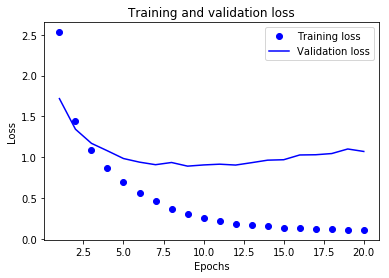

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

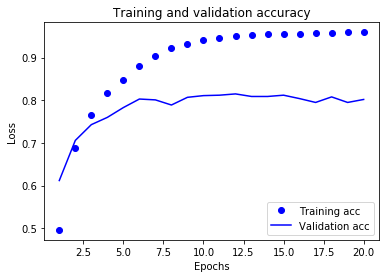

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The network begins to overfit after nine epochs. Let’s train a new network from scratch for nine epochs and then evaluate it on the test set.

In [30]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 4s 441us/step - loss: 2.5401 - acc: 0.5226 - val_loss: 1.6792 - val_acc: 0.6540
Epoch 2/9
7982/7982 [==============================] - 3s 378us/step - loss: 1.3785 - acc: 0.7096 - val_loss: 1.2825 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 3s 415us/step - loss: 1.0207 - acc: 0.7781 - val_loss: 1.1321 - val_acc: 0.7550
Epoch 4/9
7982/7982 [==============================] - 3s 398us/step - loss: 0.8003 - acc: 0.8257 - val_loss: 1.0532 - val_acc: 0.7580
Epoch 5/9
7982/7982 [==============================] - 3s 376us/step - loss: 0.6392 - acc: 0.8629 - val_loss: 0.9753 - val_acc: 0.7950
Epoch 6/9
7982/7982 [==============================] - 3s 387us/step - loss: 0.5112 - acc: 0.8930 - val_loss: 0.9097 - val_acc: 0.8130
Epoch 7/9
7982/7982 [==============================] - 3s 382us/step - loss: 0.4115 - acc: 0.9141 - val_loss: 0.8913 - val_acc: 0.8240
Epoch 8

### 5. Results on test data

In [25]:
results = model.evaluate(x_test, one_hot_test_labels)

2208/2246 [============================>.] - ETA: 0s

In [26]:
results

[1.0225298037405854, 0.77738201251968353]

This approach reaches an accuracy of ~80%.

### 6. Comparison with random baseline

Let's see what a random model would do with 46 classes

In [28]:
test_labels_copy = copy.copy(test_labels) # Make a copy of the test labels

In [29]:
np.random.shuffle(test_labels_copy) # Randomly shuffle the copy

In [30]:
hits_array = np.array(test_labels) == np.array(test_labels_copy) # Compare with actual labels

In [31]:
float(np.sum(hits_array)) / len(test_labels) # Fraction of correctly labelled by random classifier

0.182546749777382

Thus a random classifier gets a result closer to 18%.

This means our naive model does a pretty good job compared to a random baseline

### 7. Assigments:
1. Try to use only 4 units(instead of 64) in the second hidden layer of the above architecture.
2. Try to use 2 hidden layers each with 32 units
3. Try to use 2 hidden layers each with 128 units
4. Try to use only 1 hidden layer (with 64 units)
5. Try to use 3 hidden layers (each with 64 units)

### 7. Trying different models with different architectures.

In [67]:
model = models.Sequential()

# Hidden layer 1 => 64 units
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))

# Hidden layer 2 => 4 units
model.add(layers.Dense(4, activation='relu'))

# Output Softmax Layer => 46 units
model.add(layers.Dense(46, activation='softmax'))

In [68]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/30
7982/7982 [==============================] - 4s 483us/step - loss: 3.4866 - acc: 0.3354 - val_loss: 3.1429 - val_acc: 0.4080
Epoch 2/30
7982/7982 [==============================] - 3s 374us/step - loss: 2.8852 - acc: 0.4203 - val_loss: 2.7044 - val_acc: 0.4180
Epoch 3/30
7982/7982 [==============================] - 3s 374us/step - loss: 2.4410 - acc: 0.4551 - val_loss: 2.3515 - val_acc: 0.4420
Epoch 4/30
7982/7982 [==============================] - 3s 374us/step - loss: 2.0857 - acc: 0.4957 - val_loss: 2.0528 - val_acc: 0.5170
Epoch 5/30
7982/7982 [==============================] - 3s 371us/step - loss: 1.7600 - acc: 0.6279 - val_loss: 1.7715 - val_acc: 0.6420
Epoch 6/30
7982/7982 [==============================] - 3s 371us/step - loss: 1.4674 - acc: 0.6858 - val_loss: 1.5688 - val_acc: 0.6540
Epoch 7/30
7982/7982 [==============================] - 3s 372us/step - loss: 1.2744 - acc: 0.6979 - val_loss: 1.4683 - val_acc: 0.6620


###  Plotting loss and accuracy

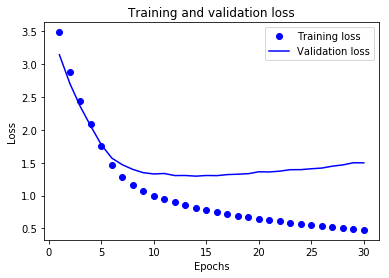

In [71]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

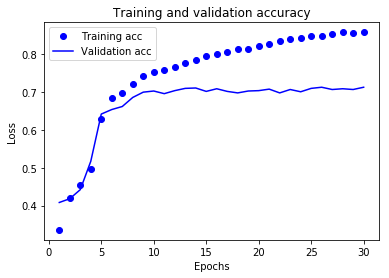

In [72]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

After around 10 epochs the model starts to overfit.

In [73]:
model = models.Sequential()

# Hidden layer 1 => 32 units
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))

# Hidden layer 2 => 32 units
model.add(layers.Dense(32, activation='relu'))

# Output Softmax Layer => 46 units
model.add(layers.Dense(46, activation='softmax'))

In [74]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 437us/step - loss: 3.3069 - acc: 0.3252 - val_loss: 2.6843 - val_acc: 0.5200
Epoch 2/20
7982/7982 [==============================] - 3s 358us/step - loss: 2.2678 - acc: 0.5898 - val_loss: 1.9453 - val_acc: 0.6120
Epoch 3/20
7982/7982 [==============================] - 3s 364us/step - loss: 1.6566 - acc: 0.6693 - val_loss: 1.5442 - val_acc: 0.6660
Epoch 4/20
7982/7982 [==============================] - 3s 340us/step - loss: 1.3134 - acc: 0.7246 - val_loss: 1.3423 - val_acc: 0.7020
Epoch 5/20
7982/7982 [==============================] - 3s 340us/step - loss: 1.0975 - acc: 0.7642 - val_loss: 1.2172 - val_acc: 0.7360
Epoch 6/20
7982/7982 [==============================] - 3s 340us/step - loss: 0.9354 - acc: 0.7989 - val_loss: 1.1289 - val_acc: 0.7580
Epoch 7/20
7982/7982 [==============================] - 3s 343us/step - loss: 0.8075 - acc: 0.8269 - val_loss: 1.0677 - val_acc: 0.7770


###  Plotting loss and accuracy

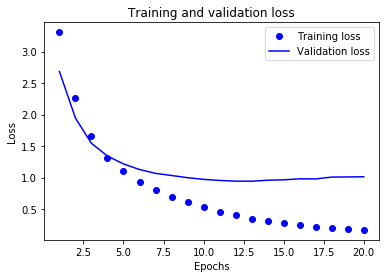

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

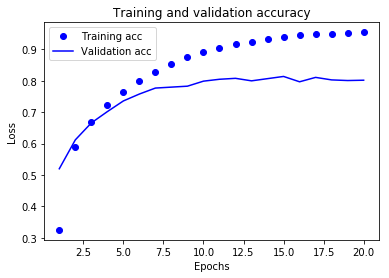

In [77]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

After 11 epochs the model starts to overfit.

In [78]:
model = models.Sequential()

# Hidden layer 1 => 128 units
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))

# Hidden layer 2 => 128 units
model.add(layers.Dense(128, activation='relu'))

# Output Softmax Layer => 46 units
model.add(layers.Dense(46, activation='softmax'))

In [79]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 5s 577us/step - loss: 2.2240 - acc: 0.5659 - val_loss: 1.3755 - val_acc: 0.6950
Epoch 2/20
7982/7982 [==============================] - 4s 463us/step - loss: 1.0902 - acc: 0.7611 - val_loss: 1.0934 - val_acc: 0.7800
Epoch 3/20
7982/7982 [==============================] - 4s 459us/step - loss: 0.7542 - acc: 0.8411 - val_loss: 0.9668 - val_acc: 0.7890
Epoch 4/20
7982/7982 [==============================] - 4s 467us/step - loss: 0.5457 - acc: 0.8849 - val_loss: 0.9480 - val_acc: 0.8210
Epoch 5/20
7982/7982 [==============================] - 4s 461us/step - loss: 0.4000 - acc: 0.9159 - val_loss: 0.9194 - val_acc: 0.7990
Epoch 6/20
7982/7982 [==============================] - 4s 460us/step - loss: 0.3119 - acc: 0.9337 - val_loss: 0.9367 - val_acc: 0.8000
Epoch 7/20
7982/7982 [==============================] - 4s 456us/step - loss: 0.2453 - acc: 0.9435 - val_loss: 0.9083 - val_acc: 0.8120


###  Plotting loss and accuracy

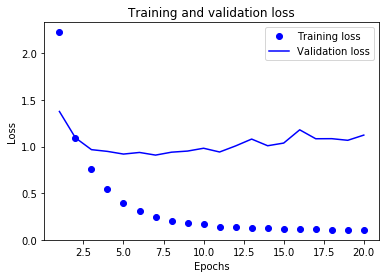

In [81]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

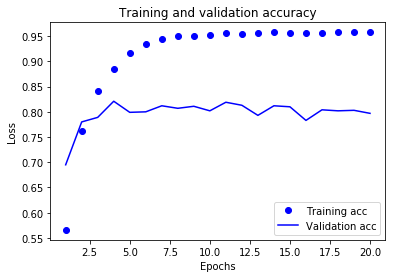

In [82]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

After 5 epochs the model starts to overfit.

In [83]:
model = models.Sequential()

# Hidden layer 1 => 64 units
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))

# Output Softmax Layer => 46 units
model.add(layers.Dense(46, activation='softmax'))

In [84]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 4s 503us/step - loss: 2.6259 - acc: 0.5596 - val_loss: 1.8484 - val_acc: 0.6730
Epoch 2/20
7982/7982 [==============================] - 3s 398us/step - loss: 1.4824 - acc: 0.7326 - val_loss: 1.3511 - val_acc: 0.7330
Epoch 3/20
7982/7982 [==============================] - 3s 376us/step - loss: 1.0653 - acc: 0.7942 - val_loss: 1.1379 - val_acc: 0.7710
Epoch 4/20
7982/7982 [==============================] - 3s 384us/step - loss: 0.8275 - acc: 0.8374 - val_loss: 1.0099 - val_acc: 0.7970
Epoch 5/20
7982/7982 [==============================] - 3s 380us/step - loss: 0.6666 - acc: 0.8736 - val_loss: 0.9374 - val_acc: 0.8020
Epoch 6/20
7982/7982 [==============================] - 3s 376us/step - loss: 0.5456 - acc: 0.8949 - val_loss: 0.8780 - val_acc: 0.8130
Epoch 7/20
7982/7982 [==============================] - 3s 378us/step - loss: 0.4510 - acc: 0.9121 - val_loss: 0.8502 - val_acc: 0.8200


###  Plotting loss and accuracy

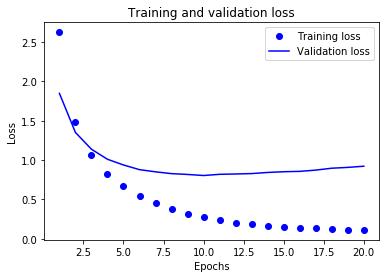

In [86]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

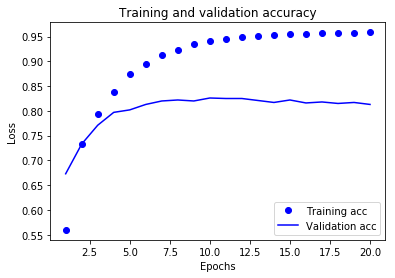

In [87]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

After 9 epochs the model starts to overfit.

In [88]:
model = models.Sequential()

# Hidden layer 1 => 64 units
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))

# Hidden layer 2 => 64 units
model.add(layers.Dense(64, activation='relu'))

# Hidden layer 3 => 64 units
model.add(layers.Dense(64, activation='relu'))

# Output Softmax Layer => 46 units
model.add(layers.Dense(46, activation='softmax'))

In [89]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 4s 540us/step - loss: 2.6205 - acc: 0.4582 - val_loss: 1.7421 - val_acc: 0.5760
Epoch 2/20
7982/7982 [==============================] - 3s 386us/step - loss: 1.4779 - acc: 0.6562 - val_loss: 1.3724 - val_acc: 0.6760
Epoch 3/20
7982/7982 [==============================] - 3s 380us/step - loss: 1.1156 - acc: 0.7471 - val_loss: 1.2629 - val_acc: 0.7030
Epoch 4/20
7982/7982 [==============================] - 3s 383us/step - loss: 0.8807 - acc: 0.8052 - val_loss: 1.0959 - val_acc: 0.7670
Epoch 5/20
7982/7982 [==============================] - 3s 382us/step - loss: 0.7043 - acc: 0.8384 - val_loss: 1.0383 - val_acc: 0.7730
Epoch 6/20
7982/7982 [==============================] - 3s 381us/step - loss: 0.5606 - acc: 0.8716 - val_loss: 1.0049 - val_acc: 0.7890
Epoch 7/20
7982/7982 [==============================] - 3s 397us/step - loss: 0.4385 - acc: 0.9062 - val_loss: 1.0246 - val_acc: 0.7860


###  Plotting loss and accuracy

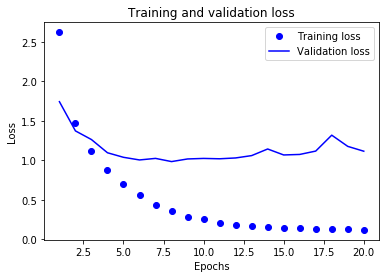

In [91]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

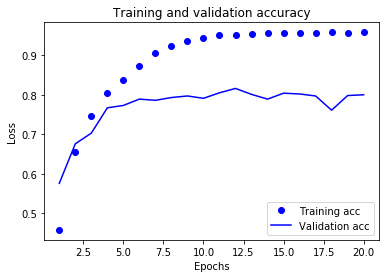

In [92]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

After 13 epochs the model starts to overfit.